# 1: IMPORTING LIBRARIES AND DATASET

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [2]:
# Printing library versions
print("Library Versions:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"TensorFlow: {tf.__version__}")

Library Versions:
NumPy: 1.18.5
Pandas: 1.1.3
Seaborn: 0.10.0
OpenCV: 4.4.0
TensorFlow: 2.3.1


In [3]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
data.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


# # **Patient Age Classification**

Age Prediction with Dataset (Tumor, Healthy Brain MRI)

In [5]:
import csv

data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        
        # Initialize a counter to keep track of the number of images per patient
        image_count = 0
        
        # Iterate over each file in the subdirectory
        for filename in os.listdir(sub_dir_path):
            # Check if the image count for the patient has reached 10
            if image_count >= 10:
                break
            
            # Extract patient ID from filename and remove additional information
            patient_id = '_'.join(filename.split('_')[:3])
            
            # Get age from data_df using patient ID
            age_row = data[data['Patient'] == patient_id]
            age = age_row.iloc[0]['age_at_initial_pathologic'] if not age_row.empty else "Unknown"
            
            # Append patient ID, image path, and age together
            image_path = os.path.join(sub_dir_path, filename)
            data_map.append([patient_id, image_path, age])
            
            # Increment the image count for the patient
            image_count += 1
            
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
data_map.sort(key=lambda x: x[0])

In [7]:
# Create a DataFrame from the collected data
df = pd.DataFrame(data_map, columns=["patient_id", "path", "age"])
df.head()

,patient_id,path,age
0,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
1,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
2,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
3,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
4,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0


In [8]:
df = df[df['age'].notna() & (df['age'] != 'Unknown')]

In [9]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

In [10]:
# Final dataframe containing only 10 images per patient
brain_df = pd.DataFrame(columns=["patient_id", "path", "age"])

# Keep only 10 images per patient
for patient_id in df_imgs['patient_id'].unique():
    brain_df = pd.concat([brain_df, df_imgs[df_imgs['patient_id'] == patient_id][:5]])

# Reset index
brain_df.reset_index(drop=True, inplace=True)

brain_df.head()

,patient_id,path,age
0,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
1,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
2,TCGA_CS_4942,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,44.0
3,TCGA_CS_4942,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,44.0
4,TCGA_CS_4942,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,44.0


In [11]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_13.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_12_mask.tif


### creating final datset

# 2: DATA VISUALIZATION

In [12]:
brain_df['age'].value_counts()

51.0    23
39.0    19
53.0    19
54.0    19
58.0    19
29.0    19
62.0    18
43.0    18
33.0    18
49.0    18
61.0    15
41.0    15
59.0    14
38.0    14
57.0    14
70.0    14
31.0    14
48.0    12
40.0    10
20.0    10
44.0    10
35.0    10
67.0    10
23.0    10
30.0     9
36.0     9
60.0     8
66.0     8
32.0     8
37.0     8
28.0     8
50.0     5
75.0     5
27.0     5
24.0     5
47.0     5
22.0     5
46.0     5
26.0     5
55.0     5
69.0     4
34.0     4
21.0     4
42.0     4
63.0     4
Name: age, dtype: int64

In [13]:
# Define age groups
def classify_age(age):
    if age >= 20 and age < 40:
        return "Ages 20-39"
    elif age >= 40 and age < 50:
        return "Ages 40-49"
    elif age >= 50 and age < 60:
        return "Ages 50-59"
    elif age >= 60 and age <= 75:
        return "Ages 60-75"

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

# Apply age grouping to brain_df
brain_df['age_group'] = brain_df['age'].apply(classify_age)

# Split data into train and test sets
train, test = train_test_split(brain_df, test_size=0.15, stratify=brain_df['age_group'])

brain_df

,patient_id,path,age,age_group
0,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0,Ages 60-69
1,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0,Ages 60-69
2,TCGA_CS_4942,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,44.0,Ages 40-49
3,TCGA_CS_4942,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,44.0,Ages 40-49
4,TCGA_CS_4942,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,44.0,Ages 40-49
...,...,...,...,...
480,TCGA_HT_A61A,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,20.0,Ages 20-29
481,TCGA_HT_A61A,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,20.0,Ages 20-29
482,TCGA_HT_A61A,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,20.0,Ages 20-29
483,TCGA_HT_A61A,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,20.0,Ages 20-29


In [15]:
brain_df['age_group'].value_counts()

Ages 50-59    118
Ages 30-39    113
Ages 40-49     97
Ages 20-29     71
Ages 60-69     67
Ages 70-75     19
Name: age_group, dtype: int64

In [16]:
# Transfer Learning
from keras_preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.15,
                             rotation_range=20,
                             horizontal_flip=True)      # Shift images horizontally by up to 20% of the wi )

# Train and validation generators using age_group
train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='path',
                                              y_col='age_group',  # Use age_group for classification
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='path',
                                              y_col='age_group',  # Use age_group for classification
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )

# Test generator using age_group
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='path',
                                                  y_col='age_group',  # Use age_group for classification
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )


Found 351 validated image filenames belonging to 6 classes.
Found 61 validated image filenames belonging to 6 classes.
Found 73 validated image filenames belonging to 6 classes.


**Traansfer Learning: DenseNet121 pre-trained model with custom head**

**Supervised Learning: Replace DenseNet121 with Custom model architecture**

In [22]:
# Transfer Learning

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import DenseNet121, ResNet50, VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Unfreeze the pretrained layers
for layer in base_model.layers:
    layer.trainable = False  # Set trainable to True to unfreeze the layer

head = base_model.output
head = GlobalAveragePooling2D()(head)
head = Flatten()(head)
head = Dense(1024, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(1024, activation='relu')(head) 
head = Dropout(0.3)(head)
head = Dense(6, activation='softmax')(head)

# Combine the base model with the custom head
model = Model(inputs=base_model.input, outputs=head)

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True
    
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']
             )

In [23]:
# Callbacks
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [ ]:
### Model training 
h = model.fit(train_generator, 
              steps_per_epoch=train_generator.n // train_generator.batch_size, 
              epochs=400, 
              validation_data=valid_generator, 
              validation_steps=valid_generator.n // valid_generator.batch_size, 
              callbacks=callbacks)

In [ ]:
# saving model achitecture in json file
model_json = model.to_json()
with open("test1", "w") as json_file:
    json_file.write(model_json)

In [ ]:
h.history.keys()

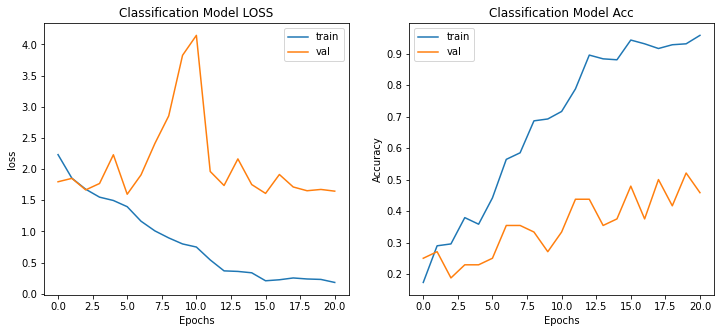

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [21]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

5/5 [==============================] - 7s 1s/step - loss: 1.5652 - accuracy: 0.5890
Test accuracy : 58.90411138534546 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels from the test set
y_true = test_generator.classes

# Generate predictions for the test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, img_path, class_index, layer_name='conv5_block16_concat'):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(x)
        class_out = preds[:, class_index]

    grads = tape.gradient(class_out, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Choose an image path from the test set
img_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif'

# Choose the class index (0 or 1 for your binary classification)
class_index = 0  # Adjust based on your model's class indices

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(model, img_path, class_index)

# Load the MRI image
img = plt.imread(img_path)

# Create a subplot to display both images
plt.figure(figsize=(12, 6))

# Plot MRI image
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('MRI Scan')

# Plot heatmap overlay
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5, interpolation='spline36')
plt.axis('off')
plt.title('Heatmap Overlay')

plt.show()

In [ ]:
img_mask = image.load_img(img_mask_path, target_size=(256, 256))

# Choose an image path from the test set
img_mask_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif'

# Plot MRI image
plt.subplot(1, 2, 1)
plt.imshow(img_mask, cmap='gray')
plt.axis('off')
plt.title('MRI Scan')

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
class_names = list(train_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)


In [ ]:
from PIL import Image
import numpy as np
import pandas as pd

# Define a function to make predictions and retrieve real age group
def predict_age_group(image_path):
    # Load an MRI image from the specified path
    image = Image.open(image_path)
    
    # Preprocess the image
    image = image.resize((256, 256))  # Resize the image to match the input size of the model
    image = np.array(image) / 255.0  # Normalize pixel values
    
    # Make a prediction using the trained model
    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_class_index = np.argmax(prediction)
    predicted_class = 'Ages 20-49' if predicted_class_index == 0 else 'Ages 50-75'  # Assuming the class indices are 0 and 1

    # Load the CSV file containing information about MRI scans
    data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

    # Extract patient ID from the image path
    patient_id = '_'.join(image_path.split('/')[-2].split('_')[:3])

    # Define a function to extract the age group based on the patient ID
    def get_age_group(patient_id):
        age_row = data[data['Patient'] == patient_id]
        if not age_row.empty:
            return age_row.iloc[0]['age_at_initial_pathologic']
        else:
            return "Unknown"

    # Get the real age group based on the patient ID
    real_age_group = get_age_group(patient_id)

    return patient_id, predicted_class, real_age_group

# List of image paths
image_paths = [
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_14.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_20.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_11.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_2.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_16.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_14.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_11.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_14.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_19.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_21.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_1.tif",
    "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_18.tif"
]

# Predict age groups and retrieve real age groups for each image
results = []
for image_path in image_paths:
    patient_id, predicted_age_group, real_age_group = predict_age_group(image_path)
    results.append([patient_id, predicted_age_group, real_age_group])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Patient ID", "Predicted Age Group", "Real Age Group"])

# Save the DataFrame to a CSV file
results_df.to_csv("/kaggle/working/predictions.csv", index=False)

# Display the DataFrame
results_df


# # # **** KNN ****

In [135]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import io, exposure
from PIL import Image

In [136]:
# Load data
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

# Prepare data_map
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        image_count = 0
        for filename in os.listdir(sub_dir_path):
            if image_count >= 10:
                break
            patient_id = '_'.join(filename.split('_')[:3])
            age_row = data[data['Patient'] == patient_id]
            age = age_row.iloc[0]['age_at_initial_pathologic'] if not age_row.empty else "Unknown"
            image_path = os.path.join(sub_dir_path, filename)
            data_map.append([patient_id, image_path, age])
            image_count += 1
    except Exception as e:
        print(e)

data_map.sort(key=lambda x: x[0])

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [137]:
# Create DataFrame
df = pd.DataFrame(data_map, columns=["patient_id", "path", "age"])
df = df[df['age'].notna() & (df['age'] != 'Unknown')]

In [138]:
# Final dataframe containing only 10 images per patient
brain_df = pd.DataFrame(columns=["patient_id", "path", "age"])

In [139]:
# Keep only 10 images per patient
for patient_id in df['patient_id'].unique():
    brain_df = pd.concat([brain_df, df[df['patient_id'] == patient_id][:10]])

In [140]:
brain_df.head()

,patient_id,path,age
0,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
1,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
2,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
3,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0
4,TCGA_CS_4941,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,67.0


In [141]:
# Reset index
brain_df.reset_index(drop=True, inplace=True)

# Define age groups
def classify_age(age):
    if age >= 20 and age < 50:
        return "Ages 20-49"
    elif age >= 50 and age <= 75:
        return "Ages 50-75"

# Apply age grouping
brain_df['age_group'] = brain_df['age'].apply(classify_age)

In [144]:
# Feature extraction using HOG
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    hog_features, hog_image = hog(np.array(img), orientations=8, pixels_per_cell=(16, 16),
                                  cells_per_block=(1, 1), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_features

# Extract features for train and test sets
train_features = [load_and_preprocess_image(path) for path in train['path']]
test_features = [load_and_preprocess_image(path) for path in test['path']]

In [145]:
# Extract features for train and test sets
train_features = [load_and_preprocess_image(path) for path in train['path']]
test_features = [load_and_preprocess_image(path) for path in test['path']]

# KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, train['age_group'])

# Predictions
train_predictions = knn.predict(train_features)
test_predictions = knn.predict(test_features)

# Evaluation
train_accuracy = accuracy_score(train['age_group'], train_predictions)
test_accuracy = accuracy_score(test['age_group'], test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.7332613390928726
Test Accuracy: 0.6707317073170732
